<a target="_blank" href="https://colab.research.google.com/github/starccato/starccato/blob/main/docs/training.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Training

This demonstrates our training  process for a Generative Adversarial Network (GAN) to generate stellar core collapse signals. The GAN is trained on a dataset of 1764 stellar core collapse signals, each with 256 timestamps.



In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Load training data

In [ ]:
from starccato.training.training_data import TrainingData

training_data = TrainingData()
training_data.summary()

```
Signal Dataset mean: -0.516 +/- 39.724
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset shape: (256, 1684)
```

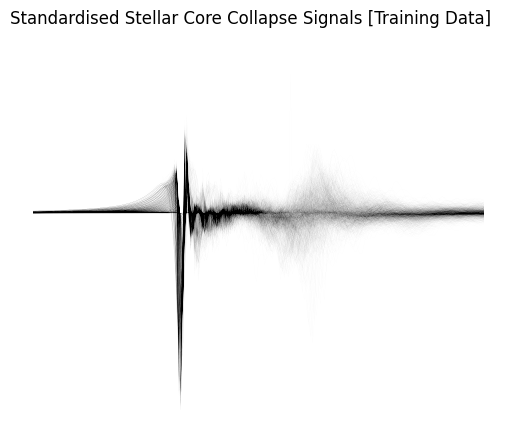

In [6]:
from starccato.plotting import overplot_signals

signals = training_data.standardize(training_data.raw_signals)[:, 130:-50]
fig = overplot_signals(signals, color="k", alpha=0.01, linewidth=0.2)
fig.axes[0].set_axis_off()
fig.axes[0].grid(False)
_ = fig.suptitle("Standardised Stellar Core Collapse Signals [Training Data]")

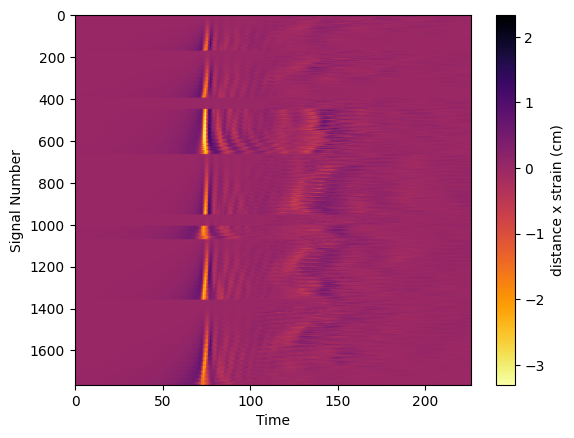

In [7]:
from starccato.plotting import plot_stacked_signals

fig = plot_stacked_signals(signals, norm='linear', cmap='inferno_r')

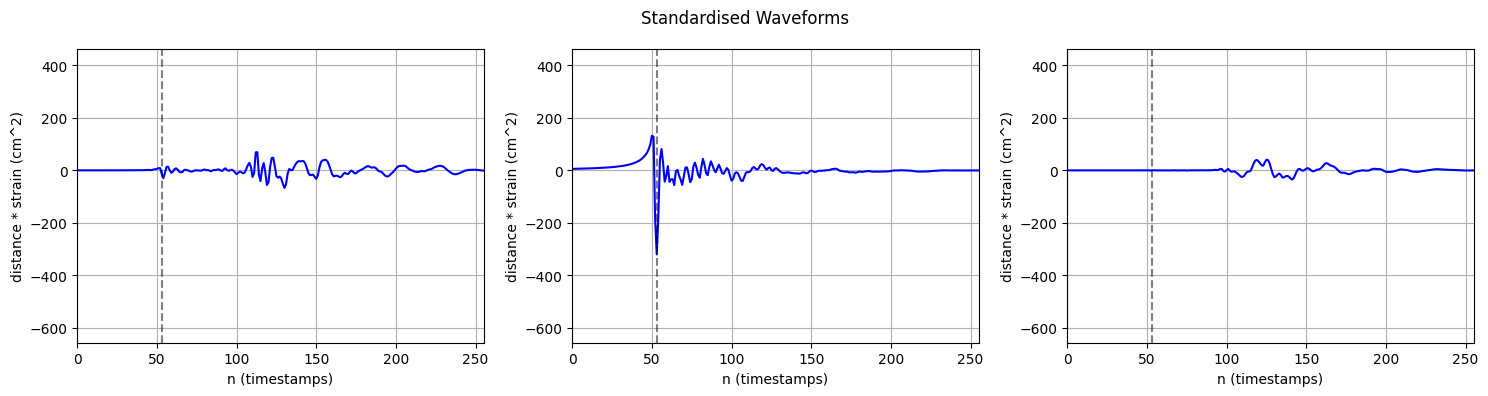

In [8]:
fig, axes = training_data.plot_waveforms(standardised=True)

## Train GAN and discriminator models

For details on the model, see the [model architecture](https://github.com/tarin-e/starccato/tree/main/src/starccato/nn).

For details on the training, see the [training code](https://github.com/tarin-e/starccato/blob/main/src/starccato/training/trainer.py).


In [ ]:
from starccato.training import train

result = train(num_epochs=128)

## Plots

### Signals
![Signals][signals_end]

### Training Loss plot
![Losses][losses]

### Gradients
| Generator Gradients | Discriminator Gradients |
|---------------------|-------------------------|
| ![Generator Gradients][gen_grads] | ![Discriminator Gradients][disc_grads] |


[gen_grads]: outdir/generator_gradients.png
[disc_grads]: outdir/discriminator_gradients.png
[losses]: outdir/losses.png
[signals_end]: outdir/signals_epoch_128.png


